##Data Collection


In [ ]:
# # Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM, Dropout, Dense

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from tensorflow.keras.preprocessing.sequence import pad_sequences

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import re
import string
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet


nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer


color = sns.color_palette()
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


##Exploratory Analysis

###Load data set

In [ ]:
# Load dataset file into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/webmd.csv")
# Output first five rows
df.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [ ]:
# Map the numerical ratings to corresponding labels
label_map = {1: 'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}
df['sentiment'] = df['Satisfaction'].map(label_map)

In [ ]:
#df= df.loc[df['Drug'].isin(['cymbalta','lisinopril solution', 'lisinopril','lexapro','hydrocodone-acetaminophen','effexor xr','lyrica','tramadol hcl er', 'tramadol hcl', 'zoloft'])]

In [ ]:
df.shape

(362806, 13)

In [ ]:
# create a new dataframe with only the reviews column and sentiment column
df = df.loc[:, ['Reviews', 'sentiment']]

In [ ]:
df.head()

,Reviews,sentiment
0,I'm a retired physician and of all the meds I ...,Positive
1,cleared me right up even with my throat hurtin...,Positive
2,why did my PTINR go from a normal of 2.5 to ov...,Neutral
3,FALLING AND DON'T REALISE IT,Negative
4,My grandfather was prescribed this medication ...,Negative


In [ ]:
# Drop all rows with a rating of 3
df = df.loc[df['sentiment'] != 'Neutral']


###Determine size of data set

In [ ]:
df = df.loc[:80000,:]

In [ ]:
df.shape

(67937, 2)

In [ ]:
df['Reviews'].apply(lambda x:len(str(x).split())).max()

424

###Train Test Split

In [ ]:
# Split the data into training and testing sets (70% for training and 30% for testing)
y= df['sentiment']
df_train, df_test = train_test_split(df, test_size=0.3,stratify=y)

# Split the training data into training and validation sets (50% for training and 50% for validation)
#df_train, df_val = train_test_split(df_train, test_size=0.5, random_state=42)


###Removing Duplicates and Empty rows

In [ ]:
#print the number of null values in each column
df_test.isnull().sum()

Reviews      1
sentiment    0
dtype: int64

In [ ]:
df_train = df_train.dropna()
df_test = df_train.dropna()

In [ ]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [ ]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Reviews'].duplicated() == True]

,Reviews,sentiment
18,,Positive
2282,back pain,Positive
4132,none,Negative
6131,ok,Negative
9329,good,Negative
10858,muscle pain,Positive
13531,headaches,Negative
16092,it helps,Negative
18566,loss of taste,Positive
21289,weight gain,Positive


In [ ]:
#print some of those rows to check
df_train[df_train['Reviews'] == df_train.iloc[3548]['Reviews']]

,Reviews,sentiment
3548,"With an Oral Bio-Availability of almost 90%, i...",Positive


In [ ]:
#removing duplicated text
index = df_train[df_train['Reviews'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [ ]:
df_train.shape

(31892, 2)

###Removing Stopwords and converting to lower cases

In [ ]:
import nltk
from nltk.corpus import stopwords

def data_cleaning(raw_data):
    raw_data = raw_data.translate(str.maketrans('', '', string.punctuation + string.digits))
    words = raw_data.lower().split()
    stop_words = set(stopwords.words("english"))
    useful_words = [w for w in words if not w in stop_words]
    return " ".join(useful_words)



In [ ]:
df_train['Reviews']= df_train['Reviews'].apply(data_cleaning)

In [ ]:
df_test["Reviews"]=df_test["Reviews"].apply(data_cleaning)

In [ ]:
df_test['Reviews']

39975    depression slight weight gain angry reading re...
67088    took months quit although sucked empty plastic...
71485    condition presciption taken worsened admitted ...
6697           works perfectly side effects within yrs use
71845    healing benefits neurotin apparent first day t...
                               ...                        
7711     medication week combonation prozac adderrall h...
74139    read article concerning doctor stella google c...
1215     seems treating condition well nerve pain subsided
46642    severe spinal conditions recently surgery augu...
32237    please dont take drug intend lose weight gain ...
Name: Reviews, Length: 47547, dtype: object

In [ ]:
df_train['Reviews']

0        depression slight weight gain angry reading re...
1        took months quit although sucked empty plastic...
2        condition presciption taken worsened admitted ...
3              works perfectly side effects within yrs use
4        healing benefits neurotin apparent first day t...
                               ...                        
31887    medication week combonation prozac adderrall h...
31888    read article concerning doctor stella google c...
31889    seems treating condition well nerve pain subsided
31890    severe spinal conditions recently surgery augu...
31891    please dont take drug intend lose weight gain ...
Name: Reviews, Length: 31892, dtype: object

###Visualizing the words majorly found through Wordclouds

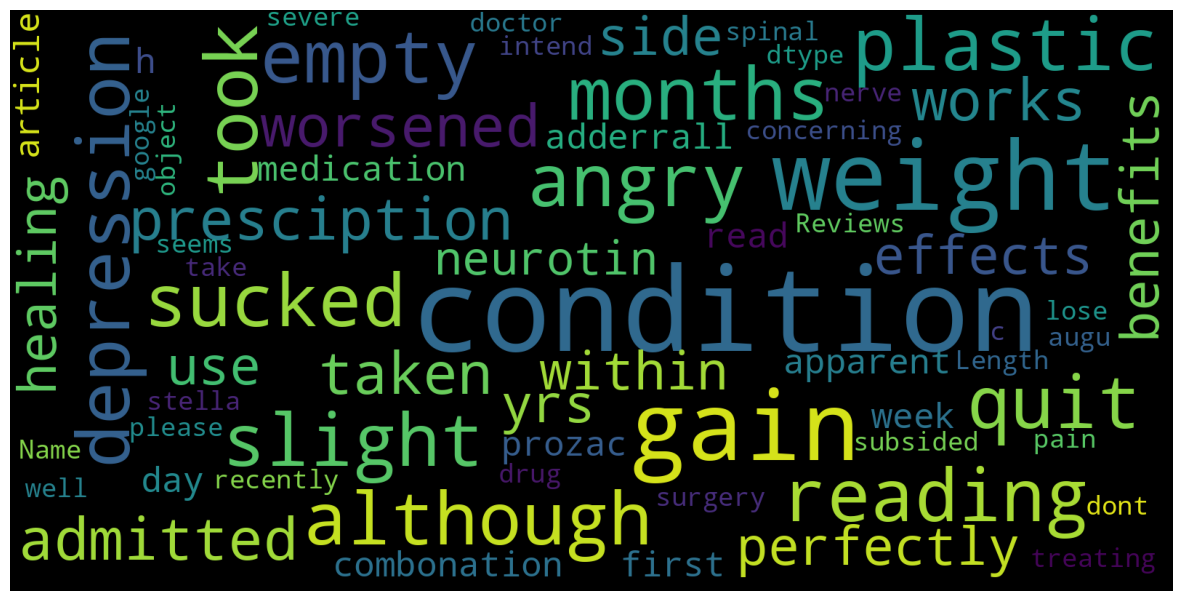

In [ ]:


def generate_wordcloud(data, title=None):
    stopwords_set = set(stopwords.words('english'))
    wordcloud = WordCloud(
        stopwords=stopwords_set,
        max_words=100,
        max_font_size=40,
        scale=4).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

generate_wordcloud(df_train['Reviews'])


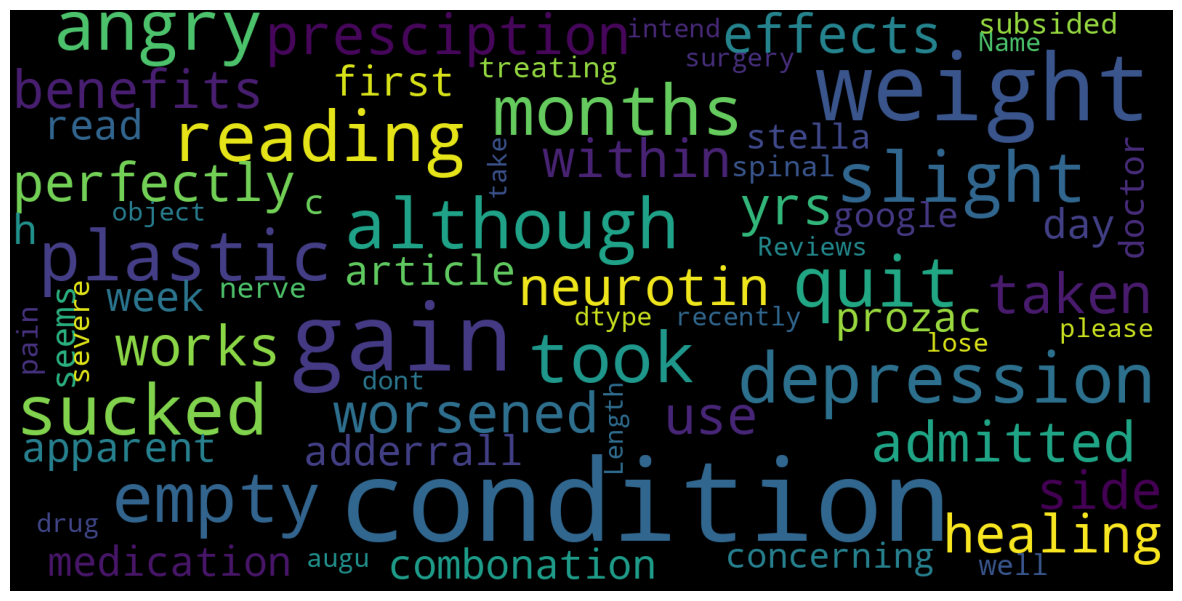

In [ ]:
generate_wordcloud(df_test["Reviews"])

###Lemmatization

####Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

# Define a function for lemmatization
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

In [ ]:
# Apply lemmatization to the 'Reviews' column in df_train
df_train['Reviews'] = df_train['Reviews'].apply(lemmatize_text)


###Visualizing class distribution

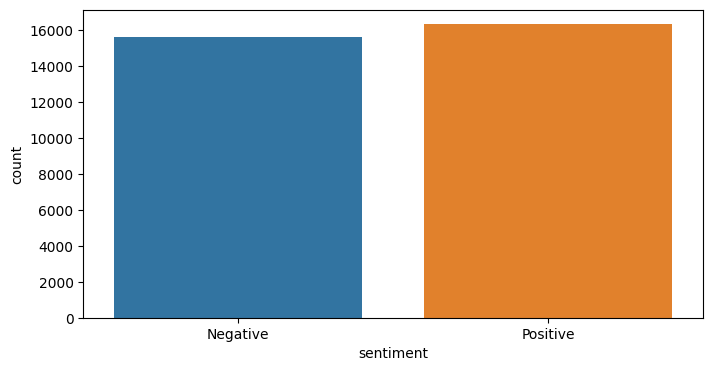

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='sentiment', data=df_train);

## Feature extraction and Model preparation


###Encoding and Transforming

In [ ]:
xtrain = df_train['Reviews']
ytrain = df_train['sentiment']

In [ ]:
xtest = df_test['Reviews']
ytest = df_test['sentiment']

In [ ]:
print(ytrain)

0        Negative
1        Positive
2        Negative
3        Positive
4        Positive
           ...   
31887    Positive
31888    Positive
31889    Positive
31890    Positive
31891    Negative
Name: sentiment, Length: 31892, dtype: object


In [ ]:
le = LabelEncoder()
ytrain = df_train.sentiment.values
ytrain = le.fit_transform(ytrain)

In [ ]:
print(ytrain)

[0 1 0 ... 1 1 0]


In [ ]:
print(ytest)

39975    Negative
67088    Positive
71485    Negative
6697     Positive
71845    Positive
           ...   
7711     Positive
74139    Positive
1215     Positive
46642    Positive
32237    Negative
Name: sentiment, Length: 47547, dtype: object


In [ ]:
ytest = df_test.sentiment.values
ytest= le.fit_transform(ytest)

In [ ]:
print(ytest)

[0 1 0 ... 1 1 0]


In [ ]:
xtrain.shape, ytrain.shape

((31892,), (31892,))

###Tokenizing

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=10000)
max_len = 600

token.fit_on_texts(list(xtrain))
xtrain_seq = token.texts_to_sequences(xtrain)
xtest_seq = token.texts_to_sequences(xtest)


#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
print(len(word_index))

39990


###Creating Embedding Matrix

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/drive/MyDrive/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [03:06, 11771.23it/s]

Found 2196016 word vectors.


In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 39990/39990 [00:00<00:00, 381750.77it/s]


##MODEL TRAINING


###Callbacks for early stopping and saving model checkpoints

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if logs.get('accuracy') > 0.95:
            print('\n Stopped Training!\n')
            self.model.stop_training = True


def train_model(model, model_name, n_epochs, batch_size, X_data, y_data, validation_split):
    checkpoint_path = model_name+"_cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,  save_weights_only=True, verbose=1)
    callbacks = myCallback()
    history = model.fit(
        X_data,
        y_data,
        steps_per_epoch=batch_size,
        epochs=n_epochs,
        validation_split=validation_split,
        verbose=1,
        callbacks=[cp_callback]
    )
    return history

### Evaluation metrics function

In [ ]:


def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



In [ ]:
def predict_func(model):
  prediction = model.predict(xtest_pad)

  y_pred = (prediction > 0.5)


  cf_matrix = confusion_matrix(y_pred, ytest)
  f1_score_calc = cf_matrix[0][0] / (cf_matrix[0][0] + 0.5 * (cf_matrix[0][1] + cf_matrix[1][0]))
  print('F1-score: %.3f' % f1_score_calc)
  print("Confusion Matrix : ", cf_matrix)
  plot_confusion_matrix(cf_matrix)
  return f1_score_calc

In [ ]:
def generate_graph(history):
    plt.plot(history.history['accuracy'], 'b')
    plt.plot(history.history['val_accuracy'], 'r')
    plt.title('Model Accuracy'),
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

###Simple RNN

In [ ]:
class Model_A():
  def __new__(self):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))

    model.add(SimpleRNN(89))
    model.add(Dropout(0.2789))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


    return model

In [ ]:
model_A = Model_A()
history_A = train_model(model_A, "model_A", 10,64, xtrain_pad, ytrain, 0.2)

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.6311
Epoch 1: saving model to model_A_cp-0001.ckpt
64/64 [==============================] - 38s 493ms/step - loss: 0.6483 - accuracy: 0.6311 - val_loss: 0.5875 - val_accuracy: 0.6900
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.5758 - accuracy: 0.7067
Epoch 2: saving model to model_A_cp-0002.ckpt
64/64 [==============================] - 32s 499ms/step - loss: 0.5758 - accuracy: 0.7067 - val_loss: 0.5521 - val_accuracy: 0.7198
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.6555
Epoch 3: saving model to model_A_cp-0003.ckpt
64/64 [==============================] - 31s 482ms/step - loss: 0.6228 - accuracy: 0.6555 - val_loss: 0.6760 - val_accuracy: 0.5782
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.6167
Epoch 4: saving model to model_A_cp-0004.ckpt
64/64 [==============================] - 31s

1486/1486 [==============================] - 67s 45ms/step
F1-score: 0.698
Confusion Matrix :  [[13577  4021]
 [ 7713 22239]]


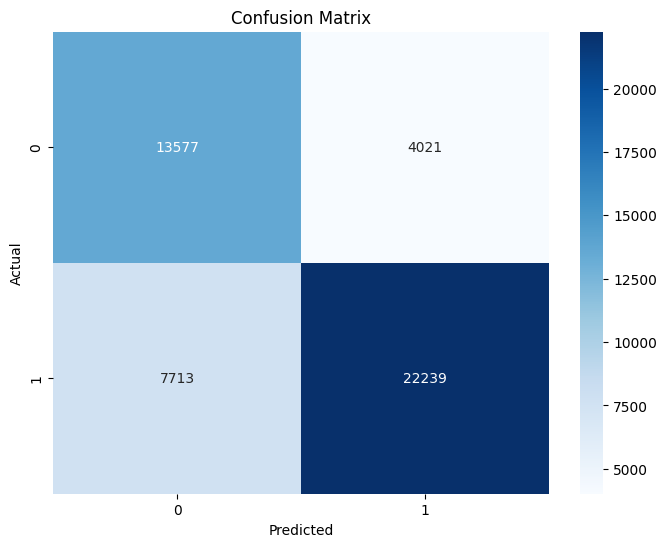

In [ ]:
model_A_score = predict_func(model_A)

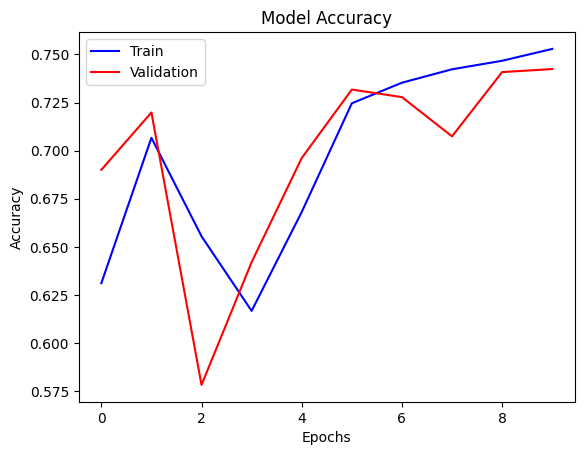

In [ ]:
generate_graph(history_A)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Assuming you have predictions and ground truth labels for the test data
y_pred = model_A.predict(xtest_pad)# Replace `model` with your trained model
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions if needed

# Accuracy
accuracy = accuracy_score(ytest, y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(ytest, y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(ytest, y_pred_binary)
print("Recall:", recall)

# F1-Score
f1 = f1_score(ytest, y_pred_binary)
print("F1-Score:", f1)

# Area Under ROC Curve (AUROC)
auroc = roc_auc_score(ytest, y_pred)
print("AUROC:", auroc)


1486/1486 [==============================] - 68s 45ms/step
Accuracy: 0.7532281808622503
Precision: 0.7424879807692307
Recall: 0.8468773800456969
F1-Score: 0.7912545363979221
AUROC: 0.813529282454567


In [ ]:
print(model_A.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 300)          11973900  
                                                                 
 simple_rnn (SimpleRNN)      (None, 89)                34710     
                                                                 
 dropout (Dropout)           (None, 89)                0         
                                                                 
 dense (Dense)               (None, 1)                 90        
                                                                 
Total params: 12,008,700
Trainable params: 34,800
Non-trainable params: 11,973,900
_________________________________________________________________
None


###LSTM MODEL

In [ ]:
class Model_B():
    def __new__(self):
        model = Sequential()
        model.add(Embedding(len(word_index) + 1,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))

        model.add(LSTM(units=61, dropout=0.2455))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model


In [ ]:
model_B = Model_B()
print(model_B.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 300)          11997300  
                                                                 
 lstm (LSTM)                 (None, 61)                88328     
                                                                 
 dense (Dense)               (None, 1)                 62        
                                                                 
Total params: 12,085,690
Trainable params: 88,390
Non-trainable params: 11,997,300
_________________________________________________________________
None


In [ ]:
model_B = Model_B()
history_B = train_model(model_B, "model_B", 10, 64, xtrain_pad, ytrain, 0.2)

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.6661
Epoch 1: saving model to model_B_cp-0001.ckpt
64/64 [==============================] - 10s 109ms/step - loss: 0.6026 - accuracy: 0.6661 - val_loss: 0.5318 - val_accuracy: 0.7325
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.5327 - accuracy: 0.7298
Epoch 2: saving model to model_B_cp-0002.ckpt
64/64 [==============================] - 7s 108ms/step - loss: 0.5327 - accuracy: 0.7298 - val_loss: 0.5064 - val_accuracy: 0.7491
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.7505
Epoch 3: saving model to model_B_cp-0003.ckpt
64/64 [==============================] - 6s 101ms/step - loss: 0.5029 - accuracy: 0.7505 - val_loss: 0.4946 - val_accuracy: 0.7616
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.4838 - accuracy: 0.7638
Epoch 4: saving model to model_B_cp-0004.ckpt
64/64 [==============================] - 6s 10

1486/1486 [==============================] - 12s 8ms/step
F1-score: 0.742
Confusion Matrix :  [[18013  9152]
 [ 3355 17029]]


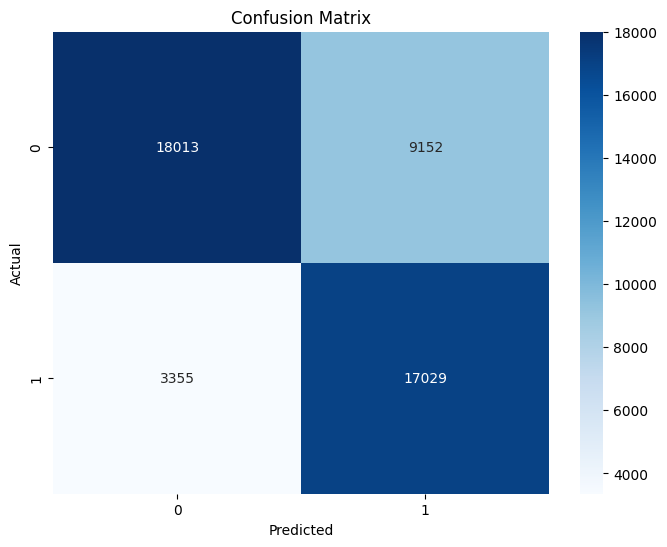

In [ ]:
model_B_score = predict_func(model_B)

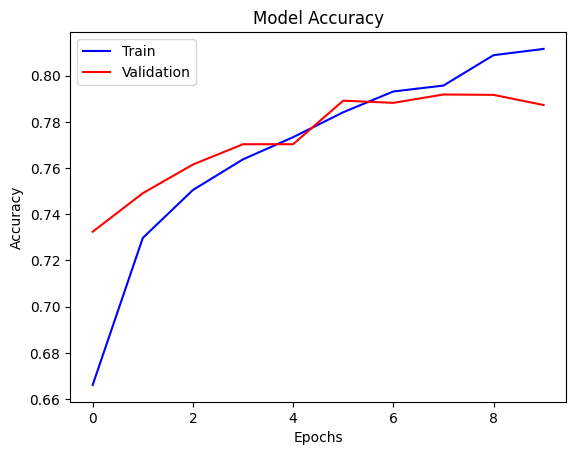

In [ ]:
generate_graph(history_B)

In [ ]:

# Assuming you have predictions and ground truth labels for the test data
y_pred = model_B.predict(xtest_pad)# Replace `model` with your trained model
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions if needed

# Accuracy
accuracy = accuracy_score(ytest, y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(ytest, y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(ytest, y_pred_binary)
print("Recall:", recall)

# F1-Score
f1 = f1_score(ytest, y_pred_binary)
print("F1-Score:", f1)

# Area Under ROC Curve (AUROC)
auroc = roc_auc_score(ytest, y_pred)
print("AUROC:", auroc)

1486/1486 [==============================] - 11s 7ms/step
Accuracy: 0.7369660770994132
Precision: 0.835410125588697
Recall: 0.6504335204919598
F1-Score: 0.731407709653173
AUROC: 0.8754167959576858


###Bi directional LSTM

In [ ]:
class Model_C():
  def __new__(self):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))

    model.add(Bidirectional(LSTM(units=104, dropout=0.27)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
model_C = Model_C()
print(model_C.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 600, 300)          11997300  
                                                                 
 bidirectional (Bidirectiona  (None, 208)              336960    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 209       
                                                                 
Total params: 12,334,469
Trainable params: 337,169
Non-trainable params: 11,997,300
_________________________________________________________________
None


In [ ]:
model_C = Model_C()
history_C = train_model(model_C, "model_C", 10, 64, xtrain_pad, ytrain, 0.2)


Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.6732
Epoch 1: saving model to model_C_cp-0001.ckpt
64/64 [==============================] - 22s 285ms/step - loss: 0.5980 - accuracy: 0.6732 - val_loss: 0.5422 - val_accuracy: 0.7304
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.5286 - accuracy: 0.7357
Epoch 2: saving model to model_C_cp-0002.ckpt
64/64 [==============================] - 18s 275ms/step - loss: 0.5286 - accuracy: 0.7357 - val_loss: 0.5080 - val_accuracy: 0.7416
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.7502
Epoch 3: saving model to model_C_cp-0003.ckpt
64/64 [==============================] - 18s 274ms/step - loss: 0.5046 - accuracy: 0.7502 - val_loss: 0.4886 - val_accuracy: 0.7634
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.4786 - accuracy: 0.7658
Epoch 4: saving model to model_C_cp-0004.ckpt
64/64 [==============================] - 18s

1486/1486 [==============================] - 23s 15ms/step
F1-score: 0.745
Confusion Matrix :  [[17759  8551]
 [ 3609 17630]]


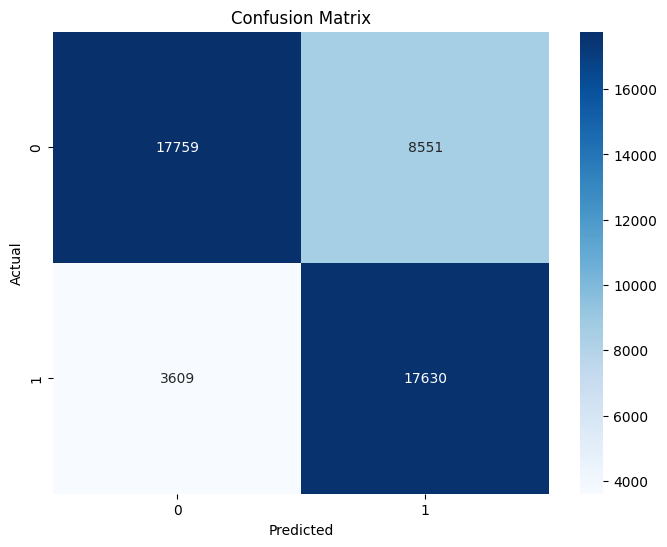

In [ ]:
model_C_score = predict_func(model_C)

In [ ]:
generate_graph(history_C)

In [ ]:

# Assuming you have predictions and ground truth labels for the test data
y_pred = model_C.predict(xtest_pad)# Replace `model` with your trained model
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions if needed

# Accuracy
accuracy = accuracy_score(ytest, y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(ytest, y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(ytest, y_pred_binary)
print("Recall:", recall)

# F1-Score
f1 = f1_score(ytest, y_pred_binary)
print("F1-Score:", f1)

# Area Under ROC Curve (AUROC)
auroc = roc_auc_score(ytest, y_pred)
print("AUROC:", auroc)

1486/1486 [==============================] - 22s 15ms/step
Accuracy: 0.7442638120675513
Precision: 0.830076745609492
Recall: 0.6733890989648982
F1-Score: 0.7435681147195277
AUROC: 0.8793615832905652


### GRU Model

In [ ]:
class Model_D():
  def __new__(self):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))
    model.add(SpatialDropout1D(0.64))
    model.add(GRU(363))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
model_D = Model_D()
print(model_D.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 600, 300)          11997300  
                                                                 
 spatial_dropout1d (SpatialD  (None, 600, 300)         0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 363)               724185    
                                                                 
 dense_2 (Dense)             (None, 1)                 364       
                                                                 
Total params: 12,721,849
Trainable params: 724,549
Non-trainable params: 11,997,300
_________________________________________________________________
None


In [ ]:
model_D = Model_D()
history_D = train_model(model_D, "model_D", 10, 64, xtrain_pad, ytrain, 0.2)


Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.6189
Epoch 1: saving model to model_D_cp-0001.ckpt
64/64 [==============================] - 30s 446ms/step - loss: 0.6486 - accuracy: 0.6189 - val_loss: 0.5948 - val_accuracy: 0.6943
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.6102 - accuracy: 0.6701
Epoch 2: saving model to model_D_cp-0002.ckpt
64/64 [==============================] - 29s 453ms/step - loss: 0.6102 - accuracy: 0.6701 - val_loss: 0.5367 - val_accuracy: 0.7318
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.5640 - accuracy: 0.7049
Epoch 3: saving model to model_D_cp-0003.ckpt
64/64 [==============================] - 29s 459ms/step - loss: 0.5640 - accuracy: 0.7049 - val_loss: 0.5137 - val_accuracy: 0.7438
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.5438 - accuracy: 0.7224
Epoch 4: saving model to model_D_cp-0004.ckpt
64/64 [==============================] - 29s

1486/1486 [==============================] - 25s 17ms/step
F1-score: 0.733
Confusion Matrix :  [[18627 10828]
 [ 2741 15353]]


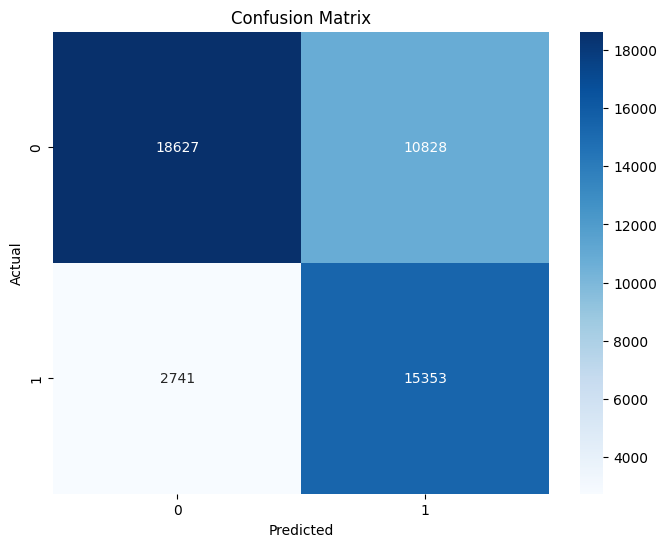

In [ ]:
model_D_score = predict_func(model_D)

In [ ]:
generate_graph(history_D)

In [ ]:

# Assuming you have predictions and ground truth labels for the test data
y_pred = model_D.predict(xtest_pad)# Replace `model` with your trained model
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions if needed

# Accuracy
accuracy = accuracy_score(ytest, y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(ytest, y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(ytest, y_pred_binary)
print("Recall:", recall)

# F1-Score
f1 = f1_score(ytest, y_pred_binary)
print("F1-Score:", f1)

# Area Under ROC Curve (AUROC)
auroc = roc_auc_score(ytest, y_pred)
print("AUROC:", auroc)

1486/1486 [==============================] - 25s 17ms/step
Accuracy: 0.7146312225283392
Precision: 0.8485133193323754
Recall: 0.5864176311065277
F1-Score: 0.6935290796160362
AUROC: 0.8641177127216401


##Model Evaluation

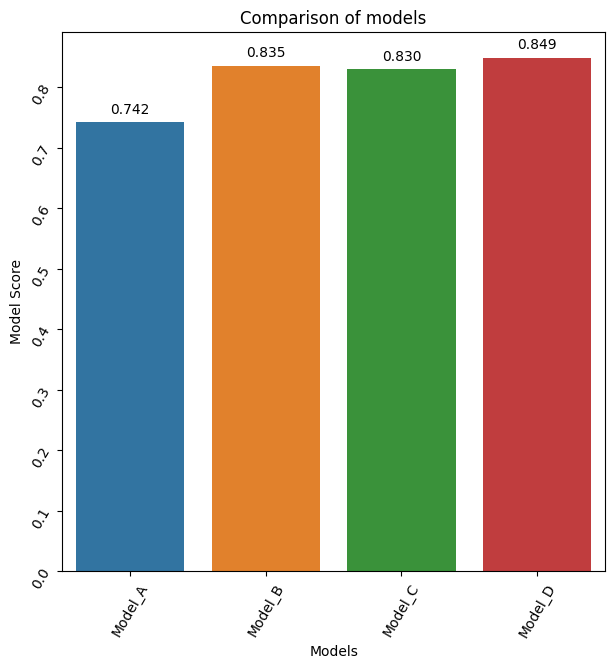

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

results_fine_tuned = {"Model_A": 0.7424879807692307,
                      "Model_B": 0.835410125588697,
                      "Model_C": 0.830076745609492,
                      "Model_D": 0.8485133193323754}

plt.figure(figsize=(7, 7))
plt.title('Comparison of models')
plt.xlabel('Models')
plt.ylabel('Model Score')
plt.xticks(rotation=60)
plt.yticks(rotation=60)

plots = sns.barplot(x=list(results_fine_tuned.keys()), y=list(results_fine_tuned.values()))

for p in plots.patches:
    plots.annotate(format(p.get_height(), '.3f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 9),
                   textcoords='offset points')

plt.show()
